In [13]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import scipy

In [14]:


# Définir les chemins 
base_path = "data"
dir_packet_loss = os.path.join(base_path, "packet_loss", "train_small")
dir_voice_origin = os.path.join(base_path, "voice_origin", "train_small")

# Fonction pour récupérer le premier fichier wav d'un dossier
def get_first_wav(directory):
    files = os.listdir(directory)
    for file in files:
        if file.endswith(".wav"):
            return os.path.join(directory, file)
    return None

# Récupérer les chemins des fichiers
file_pl = get_first_wav(dir_packet_loss)
file_vo = get_first_wav(dir_voice_origin)

# Charger les fichiers audio
if file_pl:
    y_pl, sr_pl = librosa.load(file_pl, sr=None) 
    print(f"Fichier Packet Loss chargé : {file_pl}")
    print(f"Dimensions : {y_pl.shape}, Fréquence : {sr_pl} Hz")

if file_vo:
    y_vo, sr_vo = librosa.load(file_vo, sr=None)
    print(f"Fichier Voice Origin chargé : {file_vo}")
    print(f"Dimensions : {y_vo.shape}, Fréquence : {sr_vo} Hz")

Fichier Packet Loss chargé : data\packet_loss\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (80000,), Fréquence : 8000 Hz
Fichier Voice Origin chargé : data\voice_origin\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (40000,), Fréquence : 4000 Hz


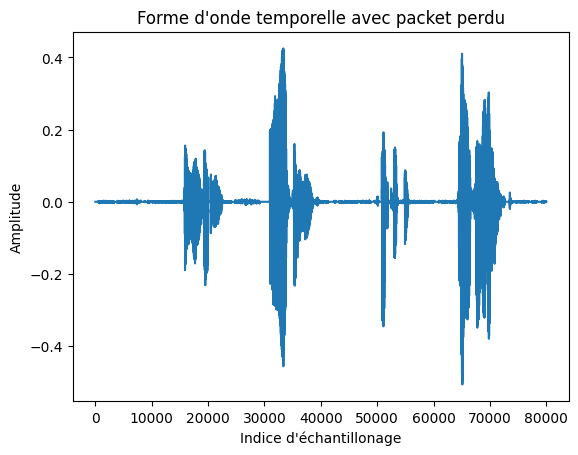

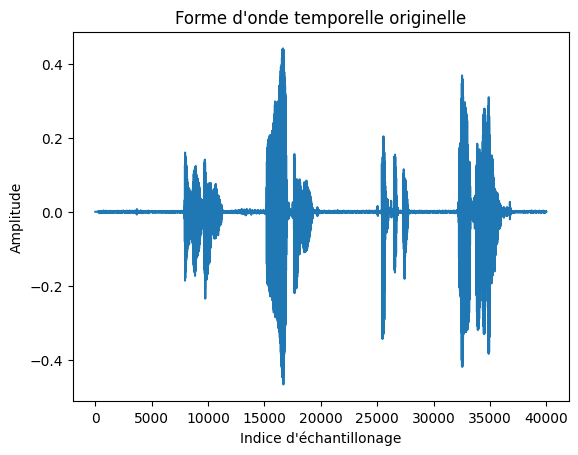

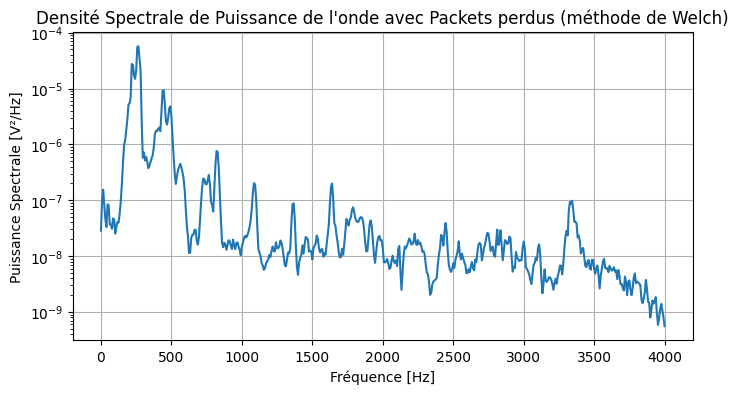

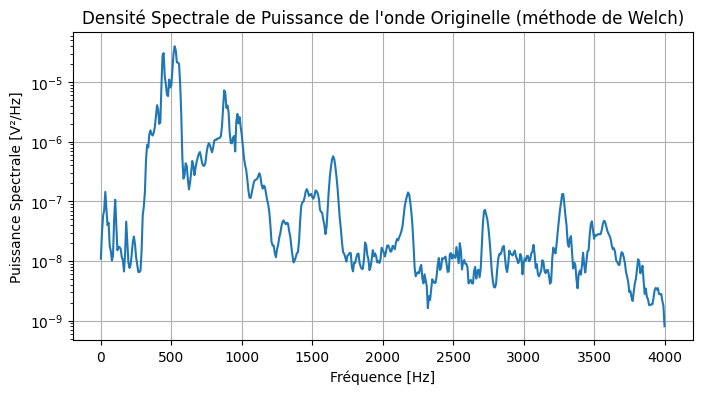

In [15]:
### FORME d'onde TEMPORELLE ###
T=[i for i in range(len(y_pl))]
plt.plot(T, y_pl)
plt.title("Forme d'onde temporelle avec packet perdu")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

plt.plot(T[0:len(y_vo)],y_vo)
plt.title("Forme d'onde temporelle originelle")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

### DENSITE SPECTRALE ###


# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_pl, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde avec Packets perdus (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_vo, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde Originelle (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

C:\Users\valex\AppData\Local\Temp\ipykernel_6460\3670535170.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')


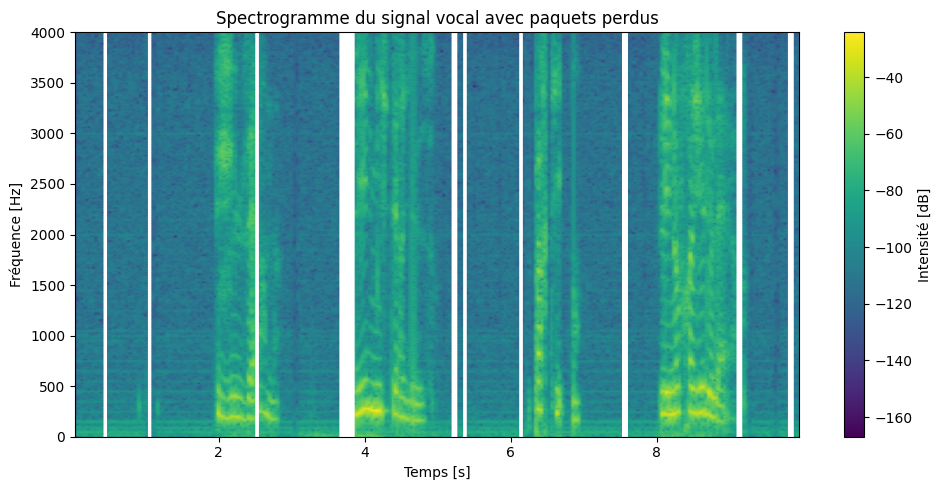

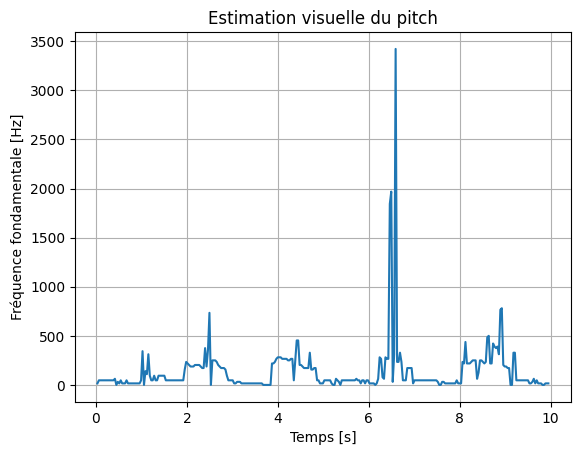

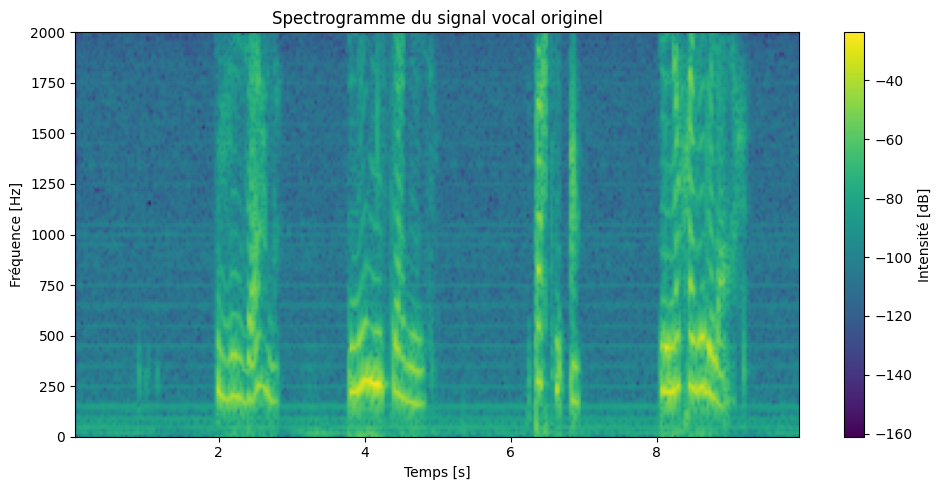

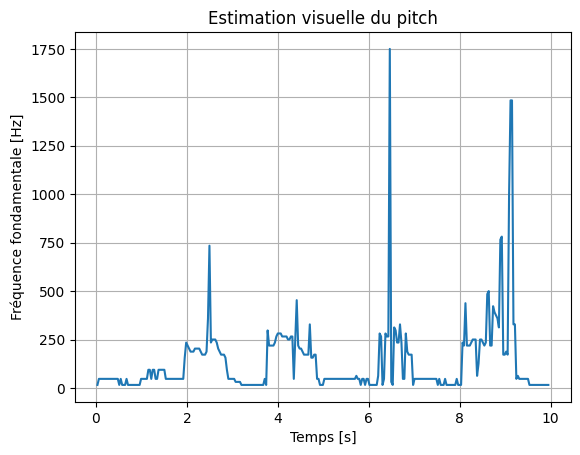

In [16]:
# --- Calcul du spectrogramme ---
f, t, Sxx_empty = scipy.signal.spectrogram(y_pl, fs=8000, nperseg=512, noverlap=256)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')
plt.title("Spectrogramme du signal vocal avec paquets perdus")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()

pitch_estim = f[np.argmax(Sxx_empty, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()


# --- Calcul du spectrogramme ---
f, t, Sxx = scipy.signal.spectrogram(y_vo, fs=4000, nperseg=256, noverlap=128)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogramme du signal vocal originel")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()
pitch_estim = f[np.argmax(Sxx, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()

Trous détectés : 42 trames manquantes sur 626.
Fichier réparé sauvegardé sous : data/packet_loss/train_small_results/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav.wav


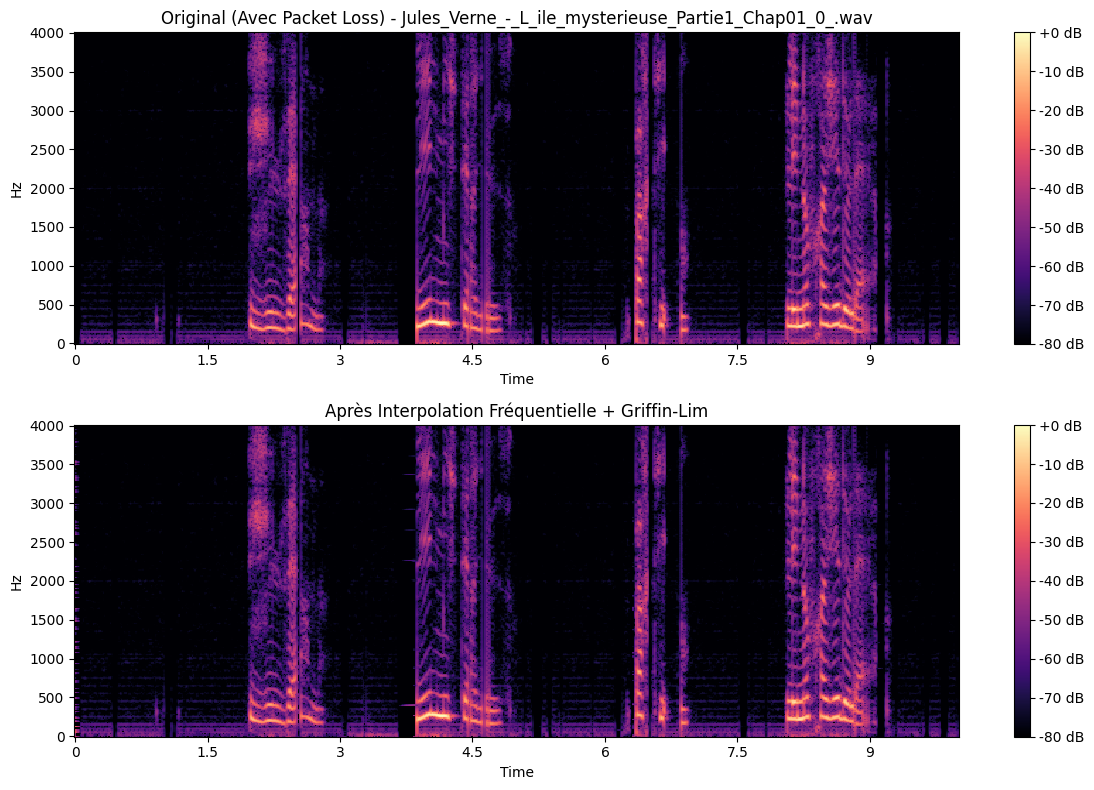

In [17]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def frequency_domain_interpolation(input_path, output_path, sr=8000):
    """
    Comble les trous de packet loss par interpolation linéaire sur le spectrogramme
    et reconstruit le signal avec Griffin-Lim.
    """
    
    # 1. Chargement du signal avec perte
    y, sr = librosa.load(input_path, sr=sr)
    
    # 2. Transformation vers le domaine fréquentiel (STFT)
    # n_fft=512 est adapté pour la voix à 8kHz (~64ms de fenêtre)
    # hop_length=128 pour un bon recouvrement
    n_fft = 512
    hop_length = 128
    
    # On récupère la Magnitude (S) et la Phase (P_original)
    # Note : On ne pourra pas vraiment utiliser P_original dans les trous (car elle est nulle ou bruitée)
    stft_matrix = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S, _ = librosa.magphase(stft_matrix) # S est la magnitude (ce qu'on voit sur l'image)

    # 3. Détection des trous (Packet Loss)
    # Un trou se manifeste par une colonne temporelle d'énergie nulle (ou quasi nulle)
    # On calcule l'énergie moyenne par trame temporelle
    frame_energy = np.mean(S, axis=0)
    
    # On crée un masque : True si c'est un trou (énergie très proche de 0), False sinon
    # 1e-5 est un seuil de sécurité pour éviter les erreurs d'arrondi
    mask_holes = frame_energy < 1e-3
    
    # Indices des trames valides (x_known) et des trous (x_missing)
    all_indices = np.arange(S.shape[1])
    known_indices = all_indices[~mask_holes]
    missing_indices = all_indices[mask_holes]

    if len(missing_indices) == 0:
        print("Aucun trou détecté dans ce fichier.")
        return y

    print(f"Trous détectés : {len(missing_indices)} trames manquantes sur {S.shape[1]}.")

    # 4. Interpolation Linéaire (Ligne par Ligne / Fréquence par Fréquence)
    S_interpolated = S.copy()
    
    # On itère sur chaque bande de fréquence (chaque ligne du spectrogramme)
    for freq_bin in range(S.shape[0]):
        # Valeurs connues pour cette fréquence
        values_known = S[freq_bin, known_indices]
        
        # bounds_error=False et fill_value="extrapolate" gèrent les cas où le trou est au tout début ou à la toute fin
        f = interp1d(known_indices, values_known, kind='cubic', bounds_error=False, fill_value="extrapolate")

        # 2. On demande à cette fonction de deviner les points manquants
        interpolated_values = f(missing_indices)

        # Petite sécurité : Les splines peuvent parfois osciller et donner des valeurs négatives impossibles en magnitude
        interpolated_values = np.maximum(interpolated_values, 0)
        # On remplit le trou
        S_interpolated[freq_bin, missing_indices] = interpolated_values

    # 5. Reconstruction du signal (Griffin-Lim)
    # On utilise Griffin-Lim car on a inventé une magnitude, mais on n'a pas la phase qui va avec.
    # L'algo va estimer une phase cohérente.
    y_reconstructed = librosa.griffinlim(S_interpolated, n_iter=32, hop_length=hop_length, win_length=n_fft)

    output_dir = os.path.dirname(output_path)

    if output_dir: 
        os.makedirs(output_dir, exist_ok=True)

    # 6. Sauvegarde
    sf.write(output_path, y_reconstructed, sr)
    print(f"Fichier réparé sauvegardé sous : {output_path}")
    
    return y, y_reconstructed, sr, S, S_interpolated

# --- EXEMPLE D'UTILISATION ET VISUALISATION ---

# On va chercher le premier fichier automatiquement pour tester
files = [f for f in os.listdir(dir_packet_loss) if f.endswith('.wav')]

if files:
    target_file = files[0] # On prend le premier
    input_wav = os.path.join(dir_packet_loss, target_file)
    output_wav = "data/packet_loss/train_small_results/" + target_file + ".wav"

    # Exécution de la fonction
    y_loss, y_rec, sr, S_orig, S_fixed = frequency_domain_interpolation(input_wav, output_wav)

    # --- AFFICHAGE GRAPHIQUE ---
    plt.figure(figsize=(12, 8))

    # 1. Spectrogramme avec Trous
    plt.subplot(2, 1, 1)
    S_db_orig = librosa.amplitude_to_db(S_orig, ref=np.max)
    librosa.display.specshow(S_db_orig, sr=sr, x_axis='time', y_axis='hz', hop_length=128)
    plt.title(f"Original (Avec Packet Loss) - {target_file}")
    plt.colorbar(format='%+2.0f dB')

    # 2. Spectrogramme Réparé
    plt.subplot(2, 1, 2)
    S_db_fixed = librosa.amplitude_to_db(S_fixed, ref=np.max)
    librosa.display.specshow(S_db_fixed, sr=sr, x_axis='time', y_axis='hz', hop_length=128)
    plt.title("Après Interpolation Fréquentielle + Griffin-Lim")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()
else:
    print("Erreur : Aucun fichier .wav trouvé dans le dossier packet_loss/train_small")

Aucune perte détectée (basée sur le silence).


AttributeError: 'int' object has no attribute 'dtype'

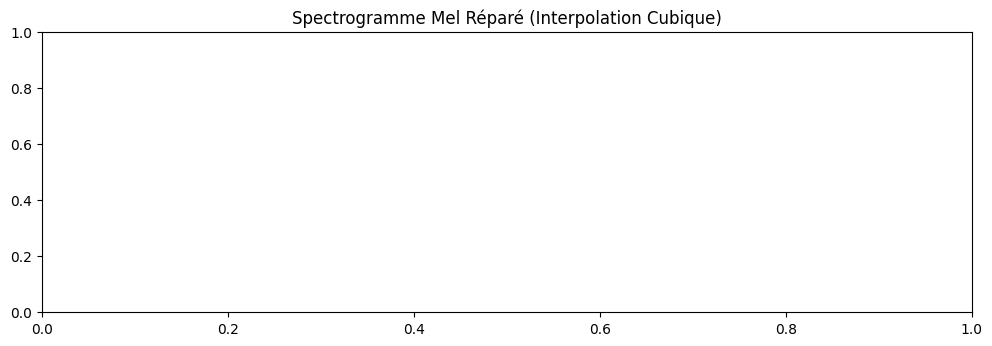

In [20]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def reparer_audio_mel_spline(y, sr, n_fft=2048, hop_length=512, n_mels=128):
    """
    Répare un signal audio avec packet loss en utilisant:
    1. Spectrogramme Mel (Perceptuel)
    2. Interpolation Cubique (Spline) sur l'axe temporel
    """
    
    # 1. Calcul du Spectrogramme (Magnitude)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # 2. Conversion vers l'échelle de Mel
    # Cela permet de travailler avec une résolution qui imite l'oreille humaine
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    S_mel = np.dot(mel_basis, S)
    
    # 3. Conversion en dB (Logarithme)
    # Important : l'interpolation fonctionne mieux sur des valeurs log (dB) que linéaires
    S_mel_db = librosa.power_to_db(S_mel**2, ref=np.max)
    
    # 4. Détection des zones de silence (Packet Loss)
    # On suppose que le packet loss = silence absolu ou très proche du silence
    # On calcule l'énergie moyenne par frame
    frame_energy = np.mean(S_mel, axis=0)
    # Seuil : on considère "perdu" si l'énergie est quasi nulle (ajustez le seuil si besoin)
    seuil_silence = 1e-4 
    lost_indices = np.where(frame_energy < seuil_silence)[0]
    known_indices = np.where(frame_energy >= seuil_silence)[0]

    # Si pas de perte détectée, on renvoie l'original
    if len(lost_indices) == 0:
        print("Aucune perte détectée (basée sur le silence).")
        return y,sr

    print(f"Réparation de {len(lost_indices)} frames manquantes avec interpolation cubique...")

    # 5. Interpolation Cubique (Spline) ligne par ligne (bande par bande)
    # On parcourt chaque bande de fréquence Mel (0 à 127)
    S_mel_db_repaired = S_mel_db.copy()
    
    for i in range(n_mels):
        y_band = S_mel_db[i, :] # Ligne de fréquence i
        
        # On prend les valeurs connues (X=temps, Y=dB)
        X_known = known_indices
        Y_known = y_band[known_indices]
        
        # Création de la fonction d'interpolation
        # 'cubic' crée une courbe douce. 'linear' ferait des traits droits.
        # fill_value="extrapolate" gère les bords si le fichier commence/finit par un trou
        try:
            interp_func = interp1d(X_known, Y_known, kind='cubic', fill_value="extrapolate")
            
            # On remplit les trous
            S_mel_db_repaired[i, lost_indices] = interp_func(lost_indices)
        except Exception as e:
            # Fallback en linéaire si cubique échoue (ex: trop peu de points)
            interp_func = interp1d(X_known, Y_known, kind='linear', fill_value="extrapolate")
            S_mel_db_repaired[i, lost_indices] = interp_func(lost_indices)

    # 6. Inversion : Retour vers le domaine linéaire
    S_mel_repaired = librosa.db_to_power(S_mel_db_repaired) # Retour en puissance
    S_mel_repaired = np.sqrt(S_mel_repaired) # Retour en magnitude
    
    # 7. Inversion Mel -> STFT (Approximation)
    # On utilise l'inverse pseudo-généralisée de la matrice Mel
    S_repaired_approx = librosa.feature.inverse.mel_to_stft(S_mel_repaired, sr=sr, n_fft=n_fft)
    
    # 8. Reconstruction de phase avec Griffin-Lim
    # Nécesaire car on a perdu la phase en passant en Mel
    y_repaired = librosa.griffinlim(S_repaired_approx, n_iter=32, hop_length=hop_length, win_length=n_fft)
    
    return y_repaired, S_mel_db_repaired

# --- EXEMPLE D'UTILISATION ---
# Remplacez par votre fichier
# On va chercher le premier fichier automatiquement pour tester
files = [f for f in os.listdir(dir_packet_loss) if f.endswith('.wav')]

if files:
    target_file = files[0] # On prend le premier
    input_wav = os.path.join(dir_packet_loss, target_file)

# Charger l'audio (simulé ici car je n'ai pas le fichier)
y, sr = librosa.load(input_wav, sr=None) 


# Appliquer la réparation
y_fixed, S_fixed = reparer_audio_mel_spline(y, sr)

# Affichage
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.title("Spectrogramme Mel Réparé (Interpolation Cubique)")
librosa.display.specshow(S_fixed, x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
plt.title("Forme d'onde (Waveform) Réparée")
librosa.display.waveshow(y_fixed, sr=sr)
plt.tight_layout()
plt.show()

# Sauvegarder le résultat
# import soundfile as sf
# sf.write('resultat_mel_spline.wav', y_fixed, sr)

Trous détectés : 417 trames manquantes (sur 626).
Fichier réparé sauvegardé sous : data/packet_loss/results_mel/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav


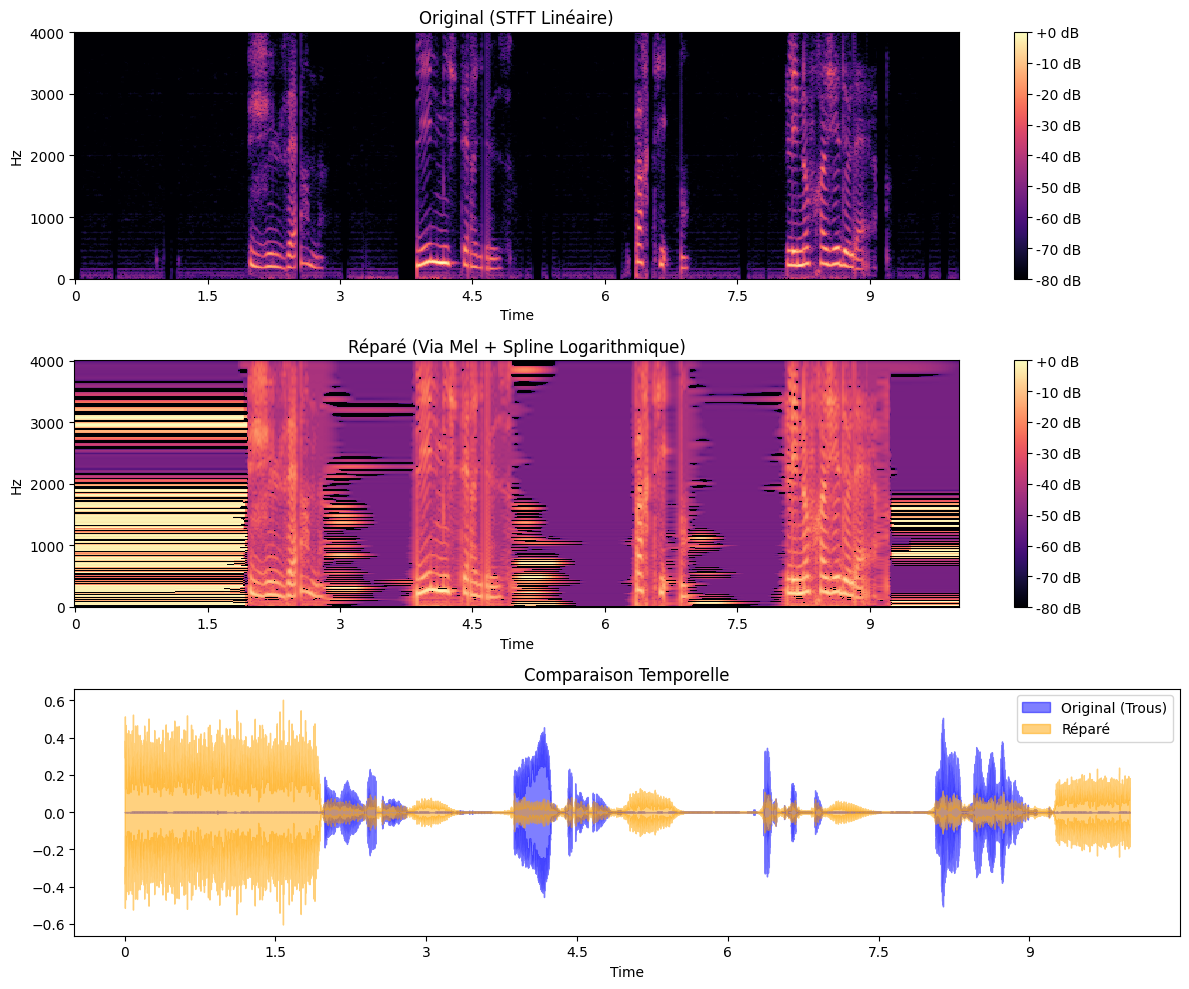

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def mel_spline_interpolation(input_path, output_path, sr=8000, n_mels=128):
    """
    Comble les trous de packet loss en utilisant :
    1. Transformation Mel (Perceptuel)
    2. Conversion en dB (Logarithmique)
    3. Interpolation Cubique (Spline)
    """
    
    # 1. Chargement du signal
    y, sr = librosa.load(input_path, sr=sr)
    
    # Paramètres STFT
    n_fft = 512
    hop_length = 128
    
    # 2. Transformation STFT (Magnitude linéaire)
    stft_matrix = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S = np.abs(stft_matrix) 

    # --- MODIFICATION CLÉ 1 : PASSAGE EN MEL ---
    # On crée une banque de filtres Mel pour passer de Hz linéaires à l'échelle Mel
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    S_mel = np.dot(mel_basis, S)
    
    # --- MODIFICATION CLÉ 2 : PASSAGE EN dB ---
    # L'interpolation fonctionne beaucoup mieux sur des dB que sur des amplitudes brutes
    # On met au carré (S**2) car power_to_db attend de la puissance
    S_mel_db = librosa.power_to_db(S_mel**2, ref=np.max)

    # 3. Détection des trous (Packet Loss)
    # On détecte sur l'énergie du spectrogramme Mel
    # On calcule l'énergie moyenne par trame temporelle (axe 0 = fréquence, axe 1 = temps)
    # Note : en dB, le silence est très négatif (ex: -80dB). 
    # On convertit le seuil "silence" en dB pour le masque.
    frame_energy_db = np.mean(S_mel_db, axis=0)

    # Seuil empirique : si l'énergie moyenne est inférieure à -70dB, c'est probablement un trou
    # (Ajustez ce seuil selon vos fichiers, -80 est le silence numérique souvent)
    mask_holes = frame_energy_db < -80.0
    
    all_indices = np.arange(S_mel_db.shape[1])
    known_indices = all_indices[~mask_holes]
    missing_indices = all_indices[mask_holes]

    if len(missing_indices) == 0:
        print("Aucun trou détecté (seuil -70dB). Vérifiez le seuil.")
        return y, y, sr, S, S # Retourne l'original

    print(f"Trous détectés : {len(missing_indices)} trames manquantes (sur {S_mel_db.shape[1]}).")

    # 4. Interpolation Cubique sur les données Mel en dB
    S_mel_db_interpolated = S_mel_db.copy()
    
    # On itère sur chaque bande Mel (0 à 127)
    for i in range(n_mels):
        values_known = S_mel_db[i, known_indices]
        
        try:
            # kind='cubic' pour des courbes douces
            f = interp1d(known_indices, values_known, kind='cubic', bounds_error=False, fill_value="extrapolate")
            interpolated_values = f(missing_indices)
            
            # Sécurité : on empêche les valeurs d'aller au-dessus de 0 dB (clipping)
            # ou trop bas (en dessous du seuil de silence) pour éviter des artefacts mathématiques
            interpolated_values = np.clip(interpolated_values, -100, 0)
            
            S_mel_db_interpolated[i, missing_indices] = interpolated_values
        except Exception as e:
            # Fallback en linéaire si pas assez de points pour une spline
            pass

    # 5. Inversion des transformations
    
    # A. Inverse dB -> Puissance -> Magnitude
    S_mel_repaired = librosa.db_to_power(S_mel_db_interpolated)
    S_mel_repaired = np.sqrt(S_mel_repaired) # Retour en magnitude
    
    # B. Inverse Mel -> STFT (Approximation mathématique)
    # Cette étape recrée les fréquences linéaires à partir des bandes Mel
    S_reconstructed_approx = librosa.feature.inverse.mel_to_stft(S_mel_repaired, sr=sr, n_fft=n_fft)

    # 6. Reconstruction Griffin-Lim
    y_reconstructed = librosa.griffinlim(S_reconstructed_approx, n_iter=32, hop_length=hop_length, win_length=n_fft)

    # Sauvegarde
    if os.path.dirname(output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sf.write(output_path, y_reconstructed, sr)
    print(f"Fichier réparé sauvegardé sous : {output_path}")
    
    return y, y_reconstructed, sr, S, S_reconstructed_approx

# --- EXEMPLE D'UTILISATION ---

# Ajustez ce chemin vers votre dossier
dir_packet_loss = "data/packet_loss/train_small/" 
# Assurez-vous que le dossier existe ou mettez un chemin absolu valide pour le test
if not os.path.exists(dir_packet_loss):
    # Pour tester sans le fichier, on crée un dossier dummy
    os.makedirs(dir_packet_loss, exist_ok=True)
    # (Optionnel) Création d'un fichier dummy si vide pour éviter l'erreur
    # ...

files = [f for f in os.listdir(dir_packet_loss) if f.endswith('.wav')]

if files:
    target_file = files[0]
    input_wav = os.path.join(dir_packet_loss, target_file)
    output_wav = "data/packet_loss/results_mel/" + target_file

    # Exécution
    # n_mels=128 donne une bonne résolution pour la voix
    y_orig, y_fix, sr, S_orig, S_fix = mel_spline_interpolation(input_wav, output_wav, sr=8000, n_mels=128)

    # --- AFFICHAGE ---
    plt.figure(figsize=(12, 10))

    # 1. Original (Linéaire)
    plt.subplot(3, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_orig, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='hz', hop_length=128)
    plt.title("Original (STFT Linéaire)")
    plt.colorbar(format='%+2.0f dB')

    # 2. Réparé (Linéaire - pour comparer visuellement)
    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_fix, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='hz', hop_length=128)
    plt.title("Réparé (Via Mel + Spline Logarithmique)")
    plt.colorbar(format='%+2.0f dB')
    
    # 3. Forme d'onde
    plt.subplot(3, 1, 3)
    librosa.display.waveshow(y_orig, sr=sr, alpha=0.5, label='Original (Trous)', color='blue')
    librosa.display.waveshow(y_fix, sr=sr, alpha=0.5, label='Réparé', color='orange')
    plt.title("Comparaison Temporelle")
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"Aucun fichier trouvé dans {dir_packet_loss}")